In [2]:
import torch
import gtl

In [ ]:
"""
To do za biblioteku:

- vratiti natrag kratka imena temperature i tipa. 
- vratiti natrag saveBaseModel. Ovako je zbunjujuce i misleading sa save_state_model. Ne zna se pod kojim je imenom snimljeno.
- import guided_transfer_learning as gtl
- pip install gtl
- guidance, guiding, guide: sve pretvori u guidance
- the name of the function plot_guidance should be: plot_guidance_distribution()
- ajust_guidance_matrix treba imati default values
- kod getGuideValue ici dublje po dimenzijama: sada isprinta prvih n samo za prvu dimenziju. Treba za sve dimenzije.

"""

# We first define a simple model 

In [371]:

# --------------------------------------------------------------------------------
# --------------------- We first define a simple model ---------------------------



class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.linear1 = torch.nn.Linear(2, 100)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(100, 25)
        self.linear3 = torch.nn.Linear(25, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, x, y, epochs, guidance_matrix=None):
    loss_function = torch.nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

    skip = 50 if epochs > 100 else 5 if epochs > 10 else 0
    
    for e in range(epochs):
        result = model(x)
        loss = loss_function(result, y)  # torch.tensor([1.00, 2.00], dtype=torch.float)
        #print(result)
        if e%skip  == 0:
            print("loss", loss) 
        model.zero_grad()
        loss.backward()
        
        # -----------------------------using gtl library-----------------------------------
        # guiding matrix will be applied for training once we create it
        if guidance_matrix is not None:
            gtl.apply_guidance(model, guidance_matrix)
            
        optimizer.step()



# Toy data for traning the model

In [4]:
# Create some data for training the model
"""
There are in total four examples, the first two examples are similar 
but are different from the other two examples.

This is a very hard problem to learn. This may require 1000s of epochs. 
"""
#this is a hard problem; it is a non-monotonic problem 
base_train_X_1 = torch.tensor([[.1, .2], [.3, .4], [.2, .3], [.4, .5]]).to(device)
base_train_Y_1 = torch.tensor([[1., .2], [3., .4], [.2, 3.], [.4, 5.]]).to(device)

"""base_train_X_2 = torch.tensor([[.1, .2], [.3, .4], [.2, .3], [.4, .5]]).to(device)
base_train_Y_2 = torch.tensor([[1., .2], [.3, 4.], [.2, 3.], [4., .5]]).to(device)

base_train_X_3 = torch.tensor([[.1, .2], [.3, .4], [.2, .3], [.4, .5]]).to(device)
base_train_Y_3 = torch.tensor([[.1, 2.], [3., .4], [2., .3], [.4, 5.]]).to(device)


#base_train_X_1 = torch.tensor([[.2, .3], [.4, .5]]).to(device)
#base_train_Y_1 = torch.tensor([[.2, 3.], [.4, 5.]]).to(device)


base_train_X = torch.tensor([[.1, .2], [.3, .4], [.2, .3], [.4, .5]]).to(device)
base_train_Y = torch.tensor([[.1, 2.], [.3, 4.], [2., .3], [4., .5]]).to(device)"""

# Train the base model with toy data

In [372]:
torch.manual_seed(3841574609)
model = TinyModel().to(device)


In [6]:

# ----------------------------using gtl library------------------------------------
#A handy function from gtl library to list all of the parameters 
#of the model together with their dimensions
param_list = gtl.list_params(model)
print(param_list)

[('linear1.weight', torch.Size([1000, 2])), ('linear1.bias', torch.Size([1000])), ('linear2.weight', torch.Size([2500, 1000])), ('linear2.bias', torch.Size([2500])), ('linear3.weight', torch.Size([2, 2500])), ('linear3.bias', torch.Size([2]))]


In [364]:

# Train the base model
train_model(model=model, x=base_train_X_1, y=base_train_Y_1, epochs=1000)
#After 100 of epochs, the error is still very high

loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

In [330]:
#Let us see the outputs that the model generates
model(base_train_X_1)

tensor([[0.9598, 0.3714],
        [2.9100, 0.4993],
        [0.2000, 2.9994],
        [0.5688, 4.7437]], device='cuda:0', grad_fn=<ReluBackward0>)

In [152]:
# ---------------------------using gtl library--------------------------------------------
# Another handy function to print the few values of each parameter name to monitor changes
print(gtl.get_param_values(model, 3))

[tensor([[ 0.6297,  0.2710],
        [-0.0504, -0.0996],
        [-0.0432,  0.0780]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([-0.2303, -0.5108, -0.6095], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[ 6.2855e-02,  8.3771e-02, -1.0304e-02,  5.8092e-02,  7.2580e-03,
          6.6107e-02, -5.7031e-02, -3.7474e-02, -3.9187e-02, -7.0541e-02,
          3.5215e-02, -9.4313e-02,  4.8020e-02, -6.0789e-02,  9.4711e-02,
         -4.8222e-02,  3.7835e-02, -2.5618e-02, -4.3687e-02, -3.9461e-02,
         -9.4086e-03, -7.4451e-02, -8.4249e-02,  9.1013e-02, -3.4199e-02,
         -1.4777e-03,  7.2794e-02, -7.0777e-02,  8.1522e-02,  7.9059e-02,
          3.7375e-02,  3.2035e-02,  1.6711e-02,  1.6239e-02, -4.7167e-02,
         -8.7775e-02,  1.3281e-02, -9.4906e-02, -3.7172e-02, -8.7751e-02,
          6.3231e-02, -4.6827e-02, -3.2754e-02,  1.9331e-02, -7.9628e-02,
         -5.1909e-03, -7.9190e-02,  9.3169e-02, -2.7922e-02,  9.7205e-02,
          6.7423e-02, -3.5152e-02,  3.4380e-02, -7

In [365]:
# -----------------------------using gtl library----------------------------------------
# Use GTL library to save the base model, as we will need it later
gtl.save_model_state(model)


WindowsPath('C:/Users/Danko/Google Drive/RGM/jednostavno/GTL_library/models/gtl_base_model.pt')

In [366]:
# We delete the model as we will not use this model any more. Instead, we will
# load the parameters from the file.
del model

# Training scouts and calculating the raw guiding matrix

Prepare data for scouts

In [367]:

#the data above are broken down into six easy problems; out of four data points in each scout
#two chosen for training. Here are all of the pairs listed:

scout_indexes = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


# ------------------------------using gtl library----------------------------------
# we use a GTL function to create scouts of the list of the data points in scout_indexes
scout_data_X = gtl.create_scout_data_from_ranged_indexes(scout_indexes, base_train_X_1)
scout_data_Y = gtl.create_scout_data_from_ranged_indexes(scout_indexes, base_train_Y_1)
print("There are ", len(scout_data_X), "scouts")
print(scout_data_X)
print(scout_data_Y)

There are  9 scouts
[tensor([[0.1000, 0.2000],
        [0.2000, 0.3000]], device='cuda:0'), tensor([[0.3000, 0.4000],
        [0.4000, 0.5000]], device='cuda:0'), tensor([[0.1000, 0.2000],
        [0.3000, 0.4000]], device='cuda:0'), tensor([[0.2000, 0.3000],
        [0.4000, 0.5000]], device='cuda:0'), tensor([[0.1000, 0.2000],
        [0.4000, 0.5000]], device='cuda:0'), tensor([[0.1000, 0.2000],
        [0.1000, 0.2000]], device='cuda:0'), tensor([[0.3000, 0.4000],
        [0.3000, 0.4000]], device='cuda:0'), tensor([[0.2000, 0.3000],
        [0.2000, 0.3000]], device='cuda:0'), tensor([[0.4000, 0.5000],
        [0.4000, 0.5000]], device='cuda:0')]
[tensor([[1.0000, 0.2000],
        [0.2000, 3.0000]], device='cuda:0'), tensor([[3.0000, 0.4000],
        [0.4000, 5.0000]], device='cuda:0'), tensor([[1.0000, 0.2000],
        [3.0000, 0.4000]], device='cuda:0'), tensor([[0.2000, 3.0000],
        [0.4000, 5.0000]], device='cuda:0'), tensor([[1.0000, 0.2000],
        [0.4000, 5.0000]], de

In [377]:
# -----------------------------using gtl library-----------------------------------------
# the library for selecting scout data can also be used with ranges of indexes 
# In the above example we listed all of the indexs of data points, but this can become
# tedious with large data sets. With large data sets one is likly to use ranges.
# A range of data can be specified in two ways, one is to use python range function. 
# The following code creates an idential list as the one used above. Note that the
# range function requires to enter i+1 for the end of the range.

scout_indexes = [list(range(0, 2)), [0, 2], [0, 3], list(range(1, 3)), [1, 3], list(range(2, 4))]

# The above approach can be confusing due to the need to enter i+1. For that reason, 
# GTL library implments the possiblity to 
# enter the exact start and end... 

# Spremanje se mozda moze pojednostaviti
# A = [[1,2,4],
#      [[7],[9]],
#      [3,5,6],
#      [[5],[20], 23, 24, [28],[30]],
#      [40, 45, 46]]
scout_indexes

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

Train scouts

In [368]:
# Now create a model for scouts and load parameters from the base model.
# These parameters are needed to continue learning from the based model. 
# Each scout is a fine-tuned version of the base model. 

s_model = TinyModel().to(device)

gtl.load_base(s_model)                       # ----------using gtl library

number_of_scouts = len(scout_data_X)

print("Training ", number_of_scouts, "scouts")

my_scouts = gtl.create_scouts(s_model)      # ----------using gtl library
for s in range(number_of_scouts):
    print("scout number:", s)
    gtl.load_base(s_model)                  # ---------------------------------gtl---------------------------------------------
    train_model(model=s_model, x=scout_data_X[s], y=scout_data_Y[s], epochs=4000)
    my_scouts.add_scout(s_model)            # ---------------------------------gtl---------------------------------------------
print("A total of", len(my_scouts), "scouts trained")

Training  9 scouts
scout number: 0
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.1000, device='cuda:0'

loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.2000, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.1500, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.6500, device='cuda:0', grad_fn=<MeanBackward0>)
scout number: 5
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6000, device='cuda:0', grad_fn=<MeanBack

loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(2.7000, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

In [336]:
guidance_matrix = my_scouts.create_raw_guidance(device) # ----------gtl

In [337]:
#saving the raw guidance matrix
gtl.save_guidance_matrix(guidance_matrix)               # ----------gtl

WindowsPath('C:/Users/Danko/Google Drive/RGM/jednostavno/GTL_library/models/guidance_matrix.pt')

In [369]:
# Release memeory for scouts as we do not need them any more
del my_scouts

# Adjusting and inspecting the guidance matrix

In [671]:
# Use get_guide_values() to print some of the values in guidance matrix
print(gtl.get_guide_values(guidance_matrix))     # ----------gtl

[('linear1.weight', tensor([[8.2375e-04, 1.5852e-03],
        [4.3842e-06, 7.8542e-06]], device='cuda:0')), ('linear1.bias', tensor([1.2678e-02, 6.5847e-05], device='cuda:0')), ('linear2.weight', tensor([[4.6878e-04, 6.2886e-04, 7.9081e-04, 1.5405e-06, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.9647e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         8.2313e-03, 5.1925e-04, 3.0816e-05, 0.0000e+00, 1.7805e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.8376e-03, 7.2917e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3181e-03, 3.4979e-04, 7.4110e-04,
         3.7043e-05, 2.4110e-09, 3.6671e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.0717e-04, 2.0028e-03, 2.9049e-03, 1.6644e-02, 9.8192e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.9099e-03, 1.1473e-03, 0.0000e+00, 0.0000e+00,
         6.5207e-05, 2.1139e-02],
        [8.5614e-04, 1.2591e-03, 1.4795e-03, 1.2943e-05, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.2526e-04, 0.0000e+

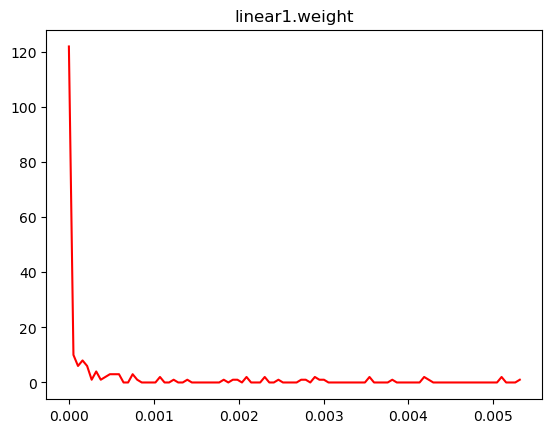

In [339]:
# A GTL function to plot the distribution of values in the guidance matrix
gtl.plot_guidance(guidance_matrix, name="linear1.weight")    # ----------gtl


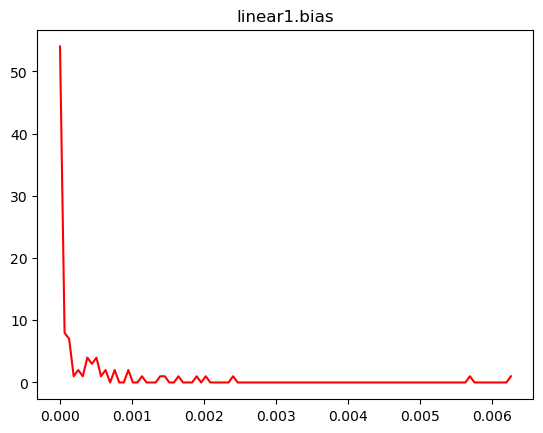

In [161]:
gtl.plot_guidance(guidance_matrix, name="linear1.bias")    # ----------gtl

In [679]:
# ----------gtl
gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.ROOM)

{'linear1.weight': tensor([[0.1183, 0.0437],
         [0.6321, 0.0540],
         [0.1029, 0.4382],
         [0.1027, 0.2947],
         [0.1544, 0.3681],
         [0.6624, 0.2211],
         [0.0000, 0.0884],
         [0.8226, 0.0984],
         [1.0000, 0.4814],
         [0.1166, 0.2151],
         [0.0480, 0.3728],
         [0.0052, 0.2545],
         [0.4877, 0.4494],
         [0.2904, 0.1328],
         [0.4577, 0.0117]], device='cuda:0'),
 'linear1.bias': tensor([0.0407, 0.0382, 0.2380, 0.3591, 0.0071, 1.0000, 0.0224, 0.5839, 0.1036,
         0.0000, 0.2891, 0.9194, 0.6891, 0.1510, 0.0479], device='cuda:0'),
 'linear2.weight': tensor([[8.4499e-02, 1.4692e-02, 1.4254e-02, 1.7595e-04, 9.2143e-03, 9.2006e-02,
          6.5578e-01, 3.8086e-01, 5.5215e-02, 2.4023e-02, 8.5731e-01, 5.1052e-02,
          3.7236e-02, 2.7930e-01, 2.1391e-02],
         [3.4721e-02, 3.0424e-01, 1.4148e-01, 6.1451e-03, 2.3934e-01, 3.8022e-01,
          2.8218e-03, 1.6453e-01, 1.6485e-02, 0.0000e+00, 1.6070e-01, 4.95

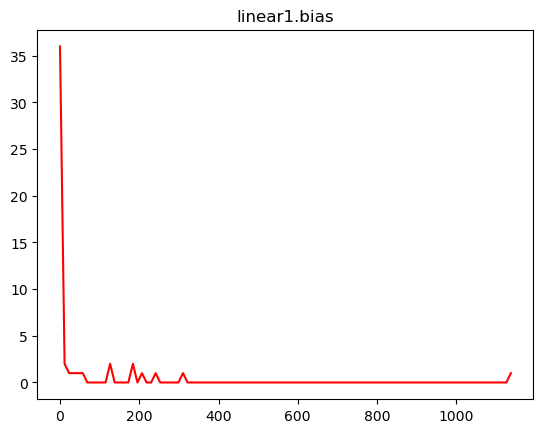

In [688]:
gtl.plot_guidance(guidance_matrix, name="linear1.bias")    # ----------gtl

In [681]:
gtl.save_guidance_matrix(guidance_matrix)    # ----------gtl

WindowsPath('C:/Users/Danko/Google Drive/RGM/jednostavno/GTL_library/models/guidance_matrix.pt')

In [ ]:

gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.CHILLY)
gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.FREEZING)
gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.WARM)
gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.EVAPORATING)
gtl.adjust_guidance_matrix(guiding_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.ICY)

# Finally performing guided transfer learning

In [320]:
#these are easy problems
base_train_X = torch.tensor([[.1, .2], [.2, .3], [.3, .4], [.4, .5]]).to(device)
base_train_Y = torch.tensor([[.1, 1.], [.1, 1.], [.1, 1.], [.1, 1.]]).to(device)

In [416]:
#these are easy problems
g_train_Xa = torch.tensor([[.1, .2], [.4, .5]]).to(device)
g_train_Ya = torch.tensor([[.1, 2.], [.4, 5.]]).to(device)

In [ ]:
"""#also and easy problem but the opposite
base_train_Xb = torch.tensor([[.1, .2], [.2, .3], [.3, .4], [.4, .5]]).to(device)
base_train_Yb = torch.tensor([[1., .1], [1., .1], [1., .1], [1., .1]]).to(device)"""

In [ ]:
base_train_X_1 = torch.tensor([[.1, .2], [.3, .4], [.2, .3], [.4, .5]]).to(device)
base_train_Y_1 = torch.tensor([[1., .2], [3., .4], [.2, 3.], [.4, 5.]]).to(device)

Without guidance

In [346]:
torch.manual_seed(3841574609)
a_model = TinyModel().to(device)
#gtl.load_base(g_model)             # ----------gtl
print()

In [347]:
train_model(model=a_model, x=base_train_X_3, y=base_train_Y_3, epochs=5000, guidance_matrix=None) 
g_model(base_train_X_3)

loss tensor(1.6205, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5239, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5235, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5230, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5224, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5216, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5208, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5199, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5188, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5176, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5162, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5145, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5124, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5100, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5070, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5034, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

tensor([[0.0951, 1.9877],
        [2.9622, 0.2893],
        [1.9812, 0.2743],
        [0.3753, 4.8312]], device='cuda:0', grad_fn=<ReluBackward0>)

With guidance

In [348]:
torch.manual_seed(3841574609)
g_model = TinyModel().to(device)
#gtl.load_base(g_model)                          # -gtl----------

guidance_matrix = gtl.load_guidance_matrix()     # -gtl----------
gtl.adjust_guidance_matrix(guidance_matrix, guide_type=gtl.GuideType.ZERO_ENFORCED_AND_NORMALIZED, temperature=gtl.Temperature.WARM)

#hundred_x(guidance_matrix)
print()

In [349]:
# Transfer learning by applying with guidance matrix
train_model(model=g_model, x=base_train_X_3, y=base_train_Y_3, epochs=5000, guidance_matrix=guidance_matrix)
g_model(base_train_X_3)

loss tensor(1.6205, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5240, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5237, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5234, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5230, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5227, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5223, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5218, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5213, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5208, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5203, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5198, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5192, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5186, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5179, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(1.5172, device='cuda:0', grad_fn=<MeanBackward0>)
loss ten

tensor([[0.0000, 2.0247],
        [2.8908, 0.3414],
        [1.8993, 0.3303],
        [0.3337, 4.8993]], device='cuda:0', grad_fn=<ReluBackward0>)

In [414]:
result = g_model(base_train_X)
result

tensor([[0.0000, 3.7537],
        [0.0000, 4.3579],
        [0.0000, 4.0169],
        [0.0093, 4.6958]], device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
train_model(model=g_model, x=base_train_Xa, y=base_train_Ya, epochs=100, guidance_matrix=guidance_matrix)

In [95]:
def hundred_x(guidance_matrix):
    for param_name in guidance_matrix:
        guidance_matrix[param_name]*= 10

In [ ]:
print(guidance_matrix)

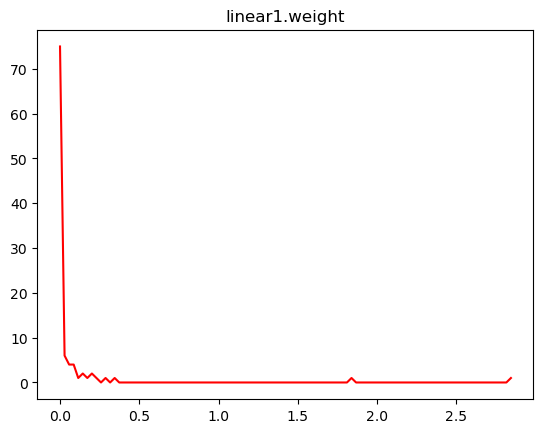

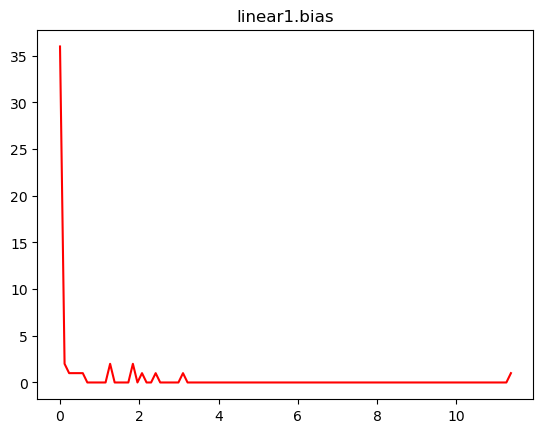

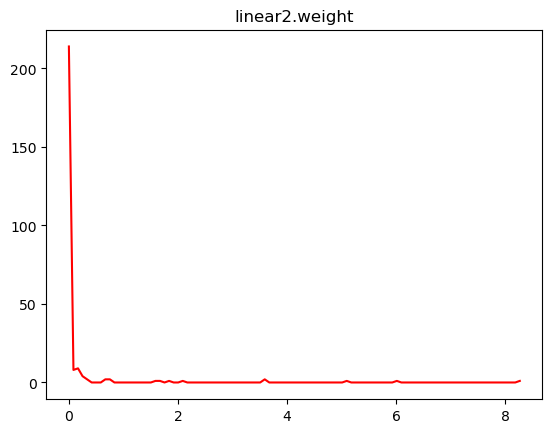

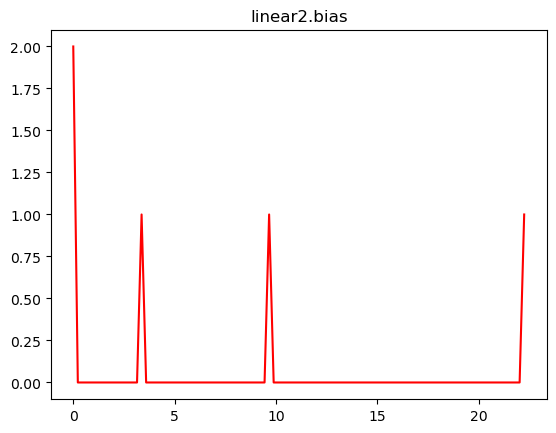

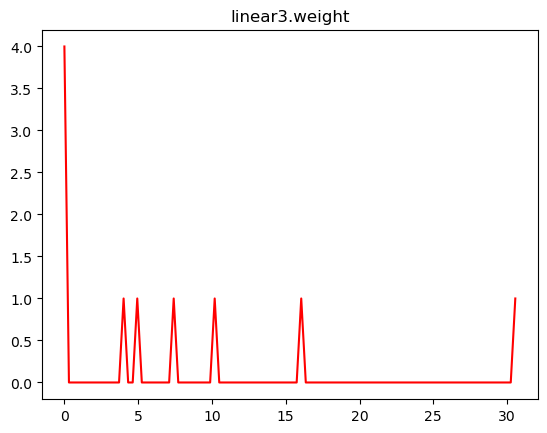

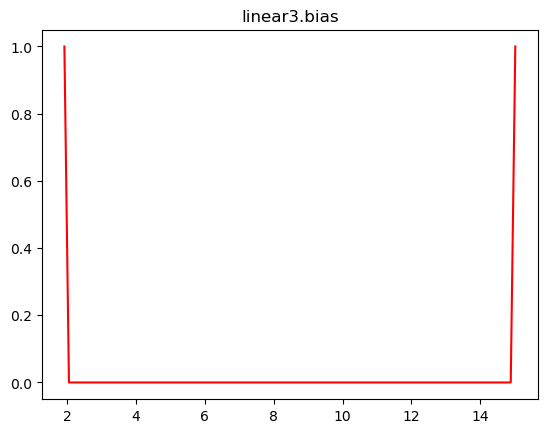

In [695]:
gtl.plot_guidance(guidance_matrix)